# Lab 5

### <span style="color:chocolate"> Submission requirements </span>

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Be sure your submitted notebook includes the output of your run (Hint: go to Kernel -> Restart Kernel and Run All Cells...)
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

This lab extends binary logistic regression to [multi-class logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression), which goes by a variety of names, including *softmax regression*, due to the use of the softmax function, which generalizes the logistic function.

In [11]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

We again load the Fashion MNIST dataset, though this time around, we'll use all 10 output classes.

In [12]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Cross-Entropy Loss

Recall the log loss function (also called binary cross-entropy):

\begin{equation}
-y log(\hat{y}) + (1−y)log(1−\hat{y})
\end{equation}

In the above formulation, it is assumed that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

## Build a model

Let's construct a model much like we did in the binary classification case, but now with a multi-class output.

---
### Exercise 1 (34 points)

Fill in the NotImplemented parts of the build_model function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output will include n_classes probabilities instead of 1.
* Use a softmax function instead of a sigmoid.
* Use a [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of binary_crossentropy. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

In [13]:
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      # YOUR CODE HERE
      units= n_classes,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # YOUR CODE HERE
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

---

Make sure your model trains. If you configured it properly, the training loss should get to ~0.55 after 5 epochs.

In [14]:
model = build_model(len(label_names), 0.01)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 1.0094 - accuracy: 0.6817 - val_loss: 0.7718 - val_accuracy: 0.7477
Epoch 2/5
844/844 [==============================] - 2s 2ms/step - loss: 0.6899 - accuracy: 0.7791 - val_loss: 0.6706 - val_accuracy: 0.7737
Epoch 3/5
844/844 [==============================] - 2s 2ms/step - loss: 0.6190 - accuracy: 0.8007 - val_loss: 0.6245 - val_accuracy: 0.7915
Epoch 4/5
844/844 [==============================] - 2s 3ms/step - loss: 0.5808 - accuracy: 0.8115 - val_loss: 0.5993 - val_accuracy: 0.7985
Epoch 5/5
844/844 [==============================] - 1s 2ms/step - loss: 0.5561 - accuracy: 0.8182 - val_loss: 0.5764 - val_accuracy: 0.8067


,loss,accuracy,val_loss,val_accuracy
0,1.009410,0.681704,0.771765,0.747667
1,0.689852,0.779056,0.670627,0.773667
2,0.619019,0.800741,0.624515,0.791500
3,0.580789,0.811463,0.599254,0.798500
4,0.556053,0.818204,0.576449,0.806667


### Evaluation Metrics

Classification metrics like accuracy, precision, and recall can all be derived from a confusion matrix which displays the counts for all pairs of true label and predicted label. Correct predictions are on the diagonal and incorrect predictions (confusions) are off the diagonal.

First, we need the predicted labels from the model.

In [15]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 0s 1ms/step
[9 2 1 ... 8 1 5]


Next, we create a confusion matrix and produce an easy-to-read visualization.

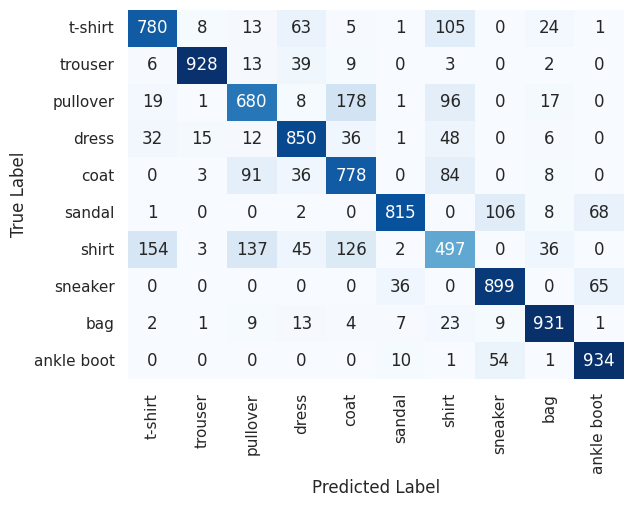

tf.Tensor(
[[780   8  13  63   5   1 105   0  24   1]
 [  6 928  13  39   9   0   3   0   2   0]
 [ 19   1 680   8 178   1  96   0  17   0]
 [ 32  15  12 850  36   1  48   0   6   0]
 [  0   3  91  36 778   0  84   0   8   0]
 [  1   0   0   2   0 815   0 106   8  68]
 [154   3 137  45 126   2 497   0  36   0]
 [  0   0   0   0   0  36   0 899   0  65]
 [  2   1   9  13   4   7  23   9 931   1]
 [  0   0   0   0   0  10   1  54   1 934]], shape=(10, 10), dtype=int32)


In [16]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()
print(confusion_matrix)

---
### Exercise 2 (33 points)

Answer the following questions by studying the confusion matrix (above).

1. Which class has the lowest precision? What is that precision? Which class has the highest precision? What is that precision?

2. For the class 'sneaker', what class is the largest source of false negatives? What about the largest source of false positives?

*Written answer:*

1. Trouser with a calculated percision of ~ 0.963 was the highest and for the lowest class it was shirt with ~0.543

2. So the hishest false positive rate was sandel at 105 and the false negative would be ankel boot with 67

---

## Analyze Errors

A crucial part of the development cycle in Machine Learning is analyzing errors to help understand the shortcomings of the model. While typically we'd want to use the development data for this purpose to preserve the purity of the test set, we'll just use our test split for simplicity.

Since the "shirt" class seems to be the source for a lot of errors, let's look at some of the confusions.

---
### Exercise 3 (33 points)

1. Display 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).
2. Display 5 images with predicted label "shirt", but true label "coat" (false positives for the "shirt" class).

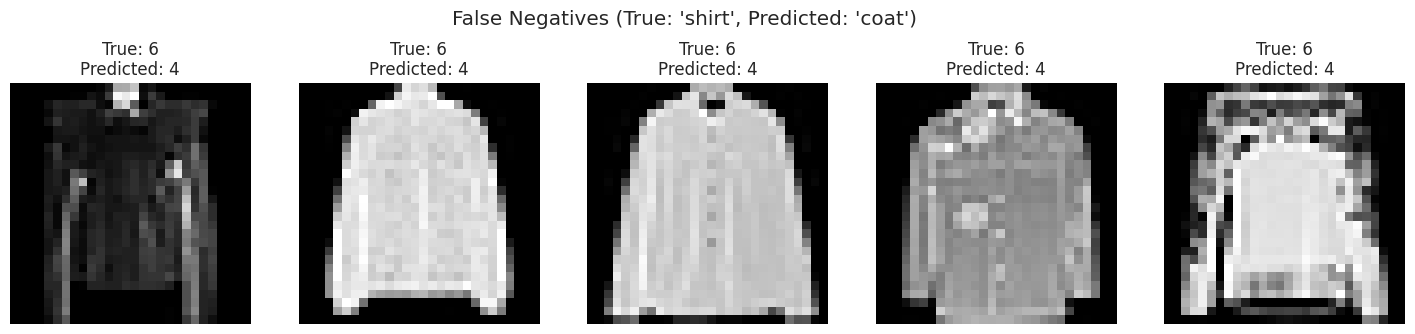

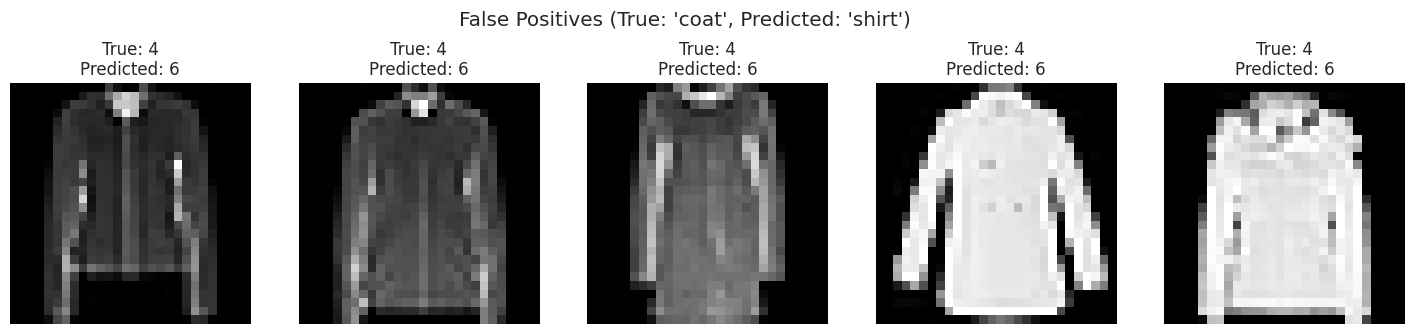

In [17]:


# Define a function to display images
def display_images(images, true_labels, test_predictions, title):
    plt.figure(figsize=(18, 4))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPredicted: {test_predictions[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Find indices of false negatives (true label "shirt" but predicted label "coat")
false_negatives_indices = np.where((Y_test == label_names.index("shirt")) & (test_predictions == label_names.index("coat")))[0]

# Find indices of false positives (true label "coat" but predicted label "shirt")
false_positives_indices = np.where((Y_test == label_names.index("coat")) & (test_predictions == label_names.index("shirt")))[0]

# Randomly select 5 examples from each category
np.random.seed(0)
false_negatives_samples = np.random.choice(false_negatives_indices, 5, replace=False)
false_positives_samples = np.random.choice(false_positives_indices, 5, replace=False)

# Display false negatives
display_images(X_test[false_negatives_samples], Y_test[false_negatives_samples], test_predictions[false_negatives_samples], "False Negatives (True: 'shirt', Predicted: 'coat')")

# Display false positives
display_images(X_test[false_positives_samples], Y_test[false_positives_samples],test_predictions[false_positives_samples], "False Positives (True: 'coat', Predicted: 'shirt')")


---

## Visualize Parameters
Finally, here's some code that helps visualize the learned parameters for each class.

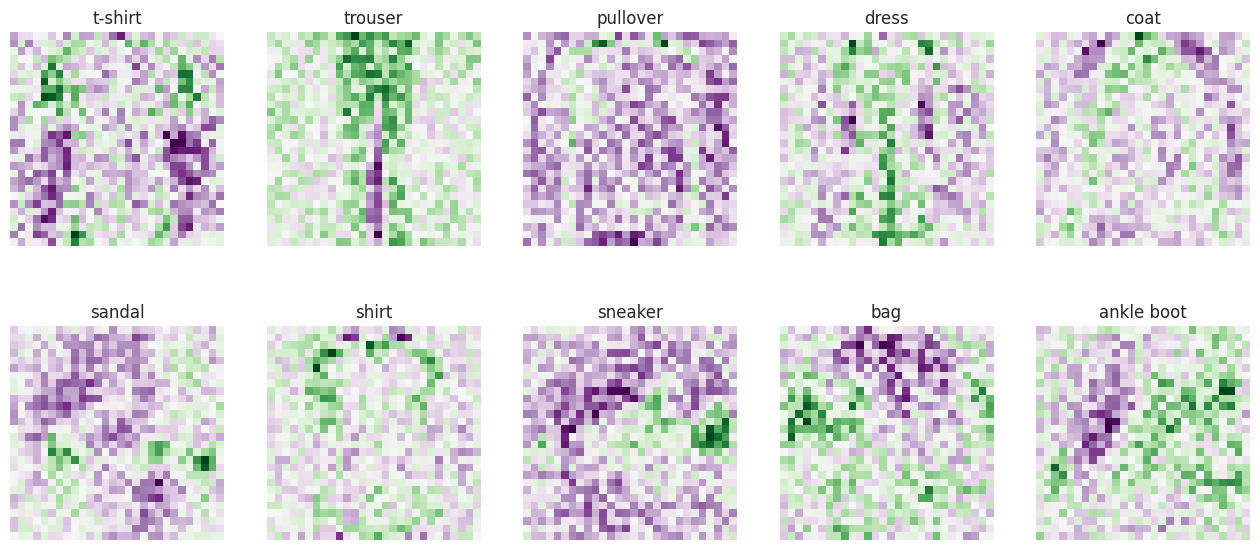

In [18]:
weights, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(2, 5, figsize=(16,7))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(weights[:,i].reshape(28,28), cmap='PRGn')
  ax.axis('off')
  ax.set_title(label_names[i])
plt.show()